In [38]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
sys.path.append("../central/") # go to parent parent dir
sys.path.append("../mpc/") # go to parent parent dir
import central_code
import mpc_code
import utils

import time

crypten.init()

torch.set_num_threads(1)
torch.set_printoptions(precision=16) # default

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/anaconda3/envs/mpc/lib/python3.7/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


### Convergence plots

In [623]:
def convergence(n_values, p, k, order=3, T_max=5):
    results_central = {}
    results_mpc = {}

    for n in n_values:

        # sample data
        data = utils.sample_dataset(n * (10 ** order), p, 0.05, k)

        # x_input = torch.tensor([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
        # theta_star = torch.tensor([140, 140, 140])
        # y_input = torch.tensor([10, 20, 30])

        # run central model
        start = time.time()
        it_err, _ = central_code.iht_central(data=data, k=k, T_max=T_max, eta=0.1, eps=0.01)
        end = time.time()
        print(f'[central] done with n={n}, with duration = {end - start}')
        results_central[n] = it_err

        # run mpc model
        start = time.time()
        it_err, _ = mpc_code.iht_mpc(data=data, k=k, T_max=T_max, eta=0.1, eps=0.01)
        end = time.time()
        print(f'[mpc] done with n={n}, with duration = {end - start}')
        results_mpc[n] = it_err

    return results_central, results_mpc

In [161]:
results_central, results_mpc = convergence(n_values=[1, 5, 10], p=64, k=20, order=3, T_max=50)

[central] done with n=1, with duration = 0.4295170307159424
[mpc] done with n=1, with duration = 615.7647559642792
[central] done with n=5, with duration = 2.1390976905822754
[mpc] done with n=5, with duration = 811.8162009716034
[central] done with n=10, with duration = 4.2004311084747314
[mpc] done with n=10, with duration = 956.2164149284363


{1: [3.6780188983124416, 3.5814209833809323, 3.488999928204681, 3.4006136489425214, 3.3161241222909954, 3.2353971768516723, 3.158302297531258, 3.084712443397324, 3.014503879360713, 2.9475560219830816, 2.8837512996150068, 2.822975026958025, 2.765115294015147, 2.7100628692517885, 2.657711116636622, 2.60795592607405, 2.5606956565817938, 2.515831091413801, 2.473265404185512, 2.4329041349305864, 2.39465517490996, 2.3584287589095254, 2.324137463704556, 2.2916962113392896, 2.2610222758693648, 2.2320352922428404, 2.2046572660506514, 2.178812582957155, 2.154428016722562, 2.1314327348475506, 2.1097583010019663, 2.089338673539592, 2.0701101995451685, 2.052011604003792, 2.0349839738227455, 2.018970736568306, 2.0039176339024323, 1.9897726898142867, 1.9764861738378592, 1.9640105595286668, 1.9523004785393083, 1.9413126706857464, 1.931005930434235, 1.9213410502637112], 5: [3.912475624729233, 3.805529345093619, 3.7030377007524735, 3.604852667286362, 3.5108306279406674, 3.4208321529162373, 3.33472178907

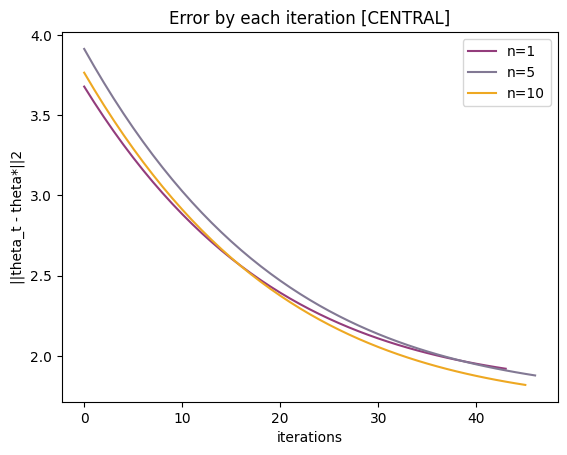

In [164]:
print(results_central)
utils.plot_error_by_iteration_and_dict_key(
    results_central,
    title=f'Error by each iteration [CENTRAL]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="n")

{1: [3.6780444716360035, 3.5814312053516706, 3.489007957390647, 3.4006061211653855, 3.3161462602936624, 3.2354162456707547, 3.1583114763450912, 3.0847302839412376, 3.0145165229356863, 2.9475685629095016, 2.883776257844767, 2.8230281560178327, 2.765171564334503, 2.7101296615965143, 2.657788574510015, 2.6080315580247784, 2.560772017101632, 2.5159075124094143, 2.473348578157459, 2.4329878284552735, 2.3947184811870748, 2.358478472905583, 2.3241912788202326, 2.29174498196497, 2.2610695863239028, 2.232087108611861, 2.204697394261776, 2.178853746077572, 2.1544681943849184, 2.131460182191, 2.109799670862636, 2.0893836320179053, 2.070154686347378, 2.052066549876619, 2.035037063625155, 2.01903182180125, 2.00396869727187, 1.9898216265777755, 1.9765434080168165, 1.9640561034347424, 1.9523330926579454, 1.9413463742618662, 1.9310474896720211, 1.9213839063561309], 5: [3.91247138377541, 3.805513536380536, 3.7030196638199246, 3.6048679418667424, 3.5108575105935356, 3.4208791083648125, 3.334765711672045

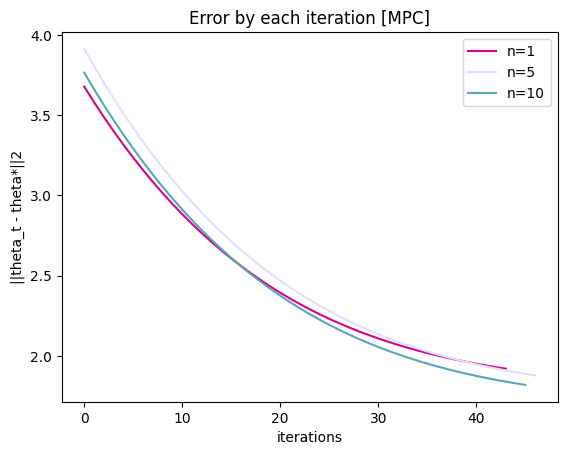

In [166]:
print(results_mpc)
utils.plot_error_by_iteration_and_dict_key(
    results_mpc,
    title=f'Error by each iteration [MPC]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="n")

### Relative error plots

In [171]:
def relative_error(n_values, p, k_values, order=3, T_max=5):
    central = {}
    mpc = {}

    for n in n_values:
        for k in k_values:
            # sample data
            data = utils.sample_dataset(n * (10 ** order), p, 0.05, k)

            # run central model
            start = time.time()
            _, rel_error = central_code.iht_central(data=data, k=k, T_max=T_max, eta=0.1, eps=0.01)
            end = time.time()
            print(f'[central] done with n={n}, with duration = {end - start}')

            if k not in central:
                central[k] = []
            central[k].append((n, rel_error))

            # run mpc model
            start = time.time()
            _, rel_error = mpc_code.iht_mpc(data=data, k=k, T_max=T_max, eta=0.1, eps=0.01)
            end = time.time()
            print(f'[mpc] done with n={n}, with duration = {end - start}')

            if k not in mpc:
                mpc[k] = []
            mpc[k].append((n, rel_error))

    return central, mpc
    

In [172]:
results_central_rel_error, results_mpc_rel_error = relative_error(n_values=[1, 5, 10], p=64, k_values=[10, 20, 50], order=3, T_max=50)

[central] done with n=1, with duration = 0.3828999996185303
[mpc] done with n=1, with duration = 556.9569888114929
[central] done with n=1, with duration = 0.3965139389038086
[mpc] done with n=1, with duration = 535.1448299884796
[central] done with n=1, with duration = 0.45147180557250977
[mpc] done with n=1, with duration = 262.514155626297
[central] done with n=5, with duration = 1.375216007232666
[mpc] done with n=5, with duration = 514.1025021076202
[central] done with n=5, with duration = 2.224226713180542
[mpc] done with n=5, with duration = 693.7201089859009
[central] done with n=5, with duration = 2.2490220069885254
[mpc] done with n=5, with duration = 415.06982707977295
[central] done with n=10, with duration = 2.9315638542175293
[mpc] done with n=10, with duration = 702.186233997345
[central] done with n=10, with duration = 4.19373893737793
[mpc] done with n=10, with duration = 888.4484510421753
[central] done with n=10, with duration = 4.576214075088501
[mpc] done with n=10

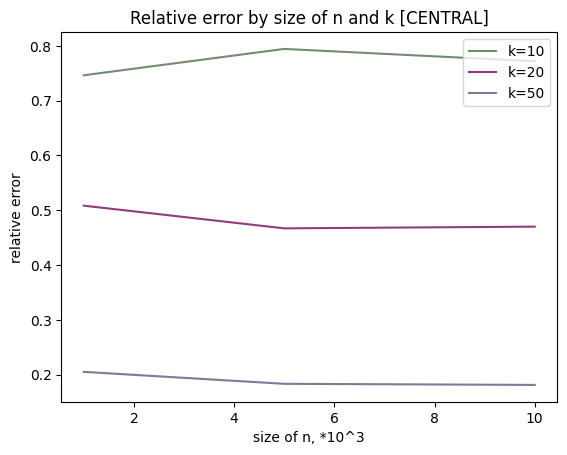

In [173]:
utils.plot_relative_error(results_central_rel_error,
                          title="Relative error by size of n and k [CENTRAL]",
                          xlabel="size of n, *10^3",
                          ylabel="relative error",
                          line_label="k")

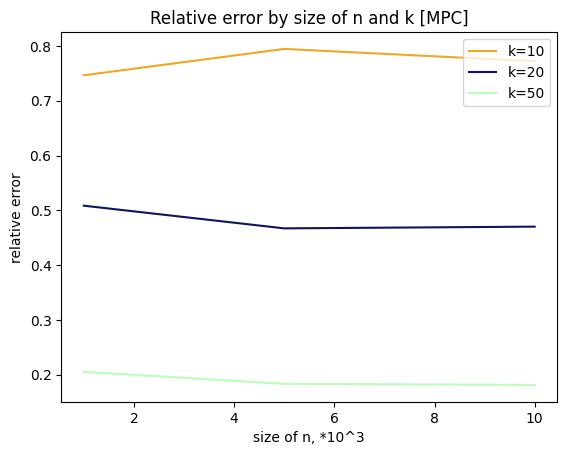

In [174]:
utils.plot_relative_error(results_mpc_rel_error,
                          title="Relative error by size of n and k [MPC]",
                          xlabel="size of n, *10^3",
                          ylabel="relative error",
                          line_label="k")

### Runtime analysis

In [184]:
def runtime_analysis(n_values, p, c_values, order=3, T_max=5):
    mpc = {}

    for n in n_values:
        for c in c_values:
            # sample data
            data = utils.sample_dataset(n * (10 ** order), p, 0.05, 50)

            # run mpc model
            start = time.time()
            _, rel_error = mpc_code.iht_mpc(data=data, k=50, T_max=T_max, c=c, eta=0.1, eps=0.01)
            end = time.time()
            print(f'[mpc] done with n={n}, c={c} with duration = {end - start}')

            if c not in mpc:
                mpc[c] = []
            mpc[c].append((n, rel_error))

    return mpc

In [185]:
runtime_mpc = runtime_analysis(n_values=[1], p=64, c_values=[0, 5, 10], order=3, T_max=5)

Local computations iteration 0 : 0.8107330799102783Local computations iteration 0 : 0.8096849918365479Local computations iteration 0 : 0.8105471134185791


ARGMIN iteration 0 : 4.017084836959839ARGMIN iteration 0 : 4.017045974731445ARGMIN iteration 0 : 4.016966104507446


Duration of iteration 0: 5.54725193977356 seconds
Local computations iteration 1 : 0.816215991973877Local computations iteration 1 : 0.8160953521728516Local computations iteration 1 : 0.8173038959503174


ARGMIN iteration 1 : 4.185179948806763ARGMIN iteration 1 : 4.185115814208984ARGMIN iteration 1 : 4.185020923614502


Duration of iteration 1: 5.452627182006836 seconds
Local computations iteration 2 : 0.8244650363922119Local computations iteration 2 : 0.8244521617889404Local computations iteration 2 : 0.8245687484741211


ARGMIN iteration 2 : 4.134851932525635ARGMIN iteration 2 : 4.134920835494995ARGMIN iteration 2 : 4.134856939315796


Duration of iteration 2: 5.6272149085998535 seconds
Local computations iteration 

## With Noise

In [268]:
def generate_gaussian_noise(mean, sigma, size):
    return np.random.normal(mean, sigma, size)

In [498]:
def generate_nb_noise(n_succ, prob_succ, size, n_servers):
    full_noise = np.zeros(size)
    for i in range(n_servers):
        noise = np.random.negative_binomial(n_succ, prob_succ, size)
        full_noise += noise
    return full_noise

In [606]:
generate_nb_noise(1, 0.01, 10, 1)

array([114.,   1., 121.,   8.,  31.,  52., 129.,   6., 165., 135.])

In [613]:
def experiment_with_noise_neg_bin(n_values, p, k, order=3, T_max=5):
    results_central = {}
    results_mpc = {}
    results_central_shorter = {}

    for n in n_values:

        # sample data
        data = utils.sample_dataset(n * (10 ** order), p, 0.05, k)

        # x_input = torch.tensor([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
        # theta_star = torch.tensor([140, 140, 140])
        # y_input = torch.tensor([10, 20, 30])

        # run central model with no noise
        noise = torch.zeros(p)
        start = time.time()
        it_err, _ = central_code.iht_central(data=data, noise=noise, k=k, T_max=T_max, eta=0.1, eps=0.01)
        end = time.time()
        results_central[(n * (10 ** order), "no-noise")] = it_err
        central_last = it_err[-1]
        central_n_it = len(it_err)

        for noise_param in [0.2, 0.1, 0.05]:
            # run central model with noise like in the Damgard paper
            p = len(data[0][0])

            # 1/2 comes from 1/(k-t) with k=3 servers, at most t=1 corrupted
            noise = generate_nb_noise(n * 10 / 2, noise_param, p, 3)

            start = time.time()
            it_err, _ = central_code.iht_central(data=data, noise=noise, k=k, T_max=T_max, eta=0.1, eps=0.01)
            end = time.time()
            results_central[(n * (10 ** order), noise_param)] = it_err
            results_central_shorter[(n * (10 ** order), noise_param)] = it_err[24:]
            central_last = it_err[-1]
            central_n_it = len(it_err)

            print("done", noise_param)

            # start = time.time()
            # it_err, _ = mpc_code.iht_mpc(data=data, noise=noise, k=k, T_max=T_max, eta=0.1, eps=0.01)
            # end = time.time()
            # print(f'[mpc] done with n={n, noise_param}, with duration = {end - start}')
            # results_mpc[(n * (10 ** order), noise_param)] = it_err
            # mpc_last = it_err[-1]
            # mpc_n_it = len(it_err)

            # print("CHECK, last iteration error difference central - mpc:", central_last - mpc_last)
            # print(f'CHECK: number of iterations:{central_n_it} vs. {mpc_n_it}')

    return results_central, results_central_shorter

In [620]:
central_noise_neg_bin, centraol_noise_neg_bin_shorter = experiment_with_noise_neg_bin(n_values=[5], p=64, k=54, order=4, T_max=50)

done 0.2
done 0.1
done 0.05


{(50000, 'no-noise'): [2.8068512233003315, 2.7128550419497985, 2.622015474187018, 2.534226201575635, 2.4493844972914824, 2.3673911044291045, 2.288150118443868, 2.2115688735886807, 2.137557833209204, 2.066030483766061, 1.9969032324570575, 1.9300953083167702, 1.8655286666750337, 1.8031278968599176, 1.7428201330346942, 1.6845349680620598, 1.6282043702925328, 1.5737626031774559, 1.5211461476104473, 1.4702936269044171, 1.4211457343144354, 1.3736451630198085, 1.327736538481676, 1.2833663530952877, 1.2404829030588955, 1.1990362273838395, 1.1589780489729977, 1.120261717697247, 1.082842155401975, 1.0466758027780168, 1.0117205680336177, 0.97793576960212, 0.9452822445464063, 0.9137218921217135, 0.8832180111678559, 0.8537351363479274, 0.8252389964123472, 0.7976964738766469, 0.7710755660649657, 0.7453453474728682, 0.7204759334046658, 0.696438444841959, 0.6732049745015949, 0.6507485540426412, 0.6290431223833787, 0.6080634950906197, 0.5877853348049575, 0.5681851226667834, 0.5492401307091109, 0.530928

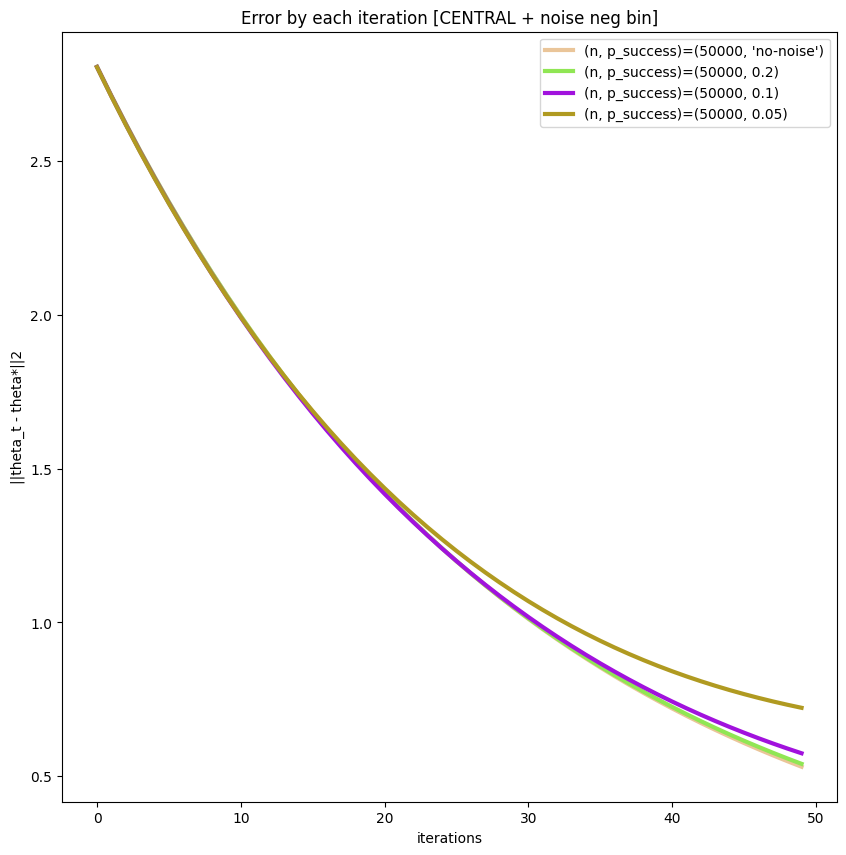

In [621]:
print(central_noise_neg_bin)
utils.plot_error_by_iteration_and_dict_key(
    central_noise_neg_bin,
    title=f'Error by each iteration [CENTRAL + noise neg bin]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(n, p_success)")

[(0.9177531881823466, 0.772561228290239, 0.5985536876244728), (0.5664755709973648, 0.9022041821095803, 0.32900059028789563), (0.6298364383833773, 0.07021234646105035, 0.8652034720739125), (0.6886732810719549, 0.6045952095662608, 0.12986319655730794), (0.06946068135331152, 0.7451550963175996, 0.9217987345315845), (0.041924949474144046, 0.6541829727223801, 0.1708042015032405), (0.7048527275022376, 0.6197206161693666, 0.9514164829391708)]


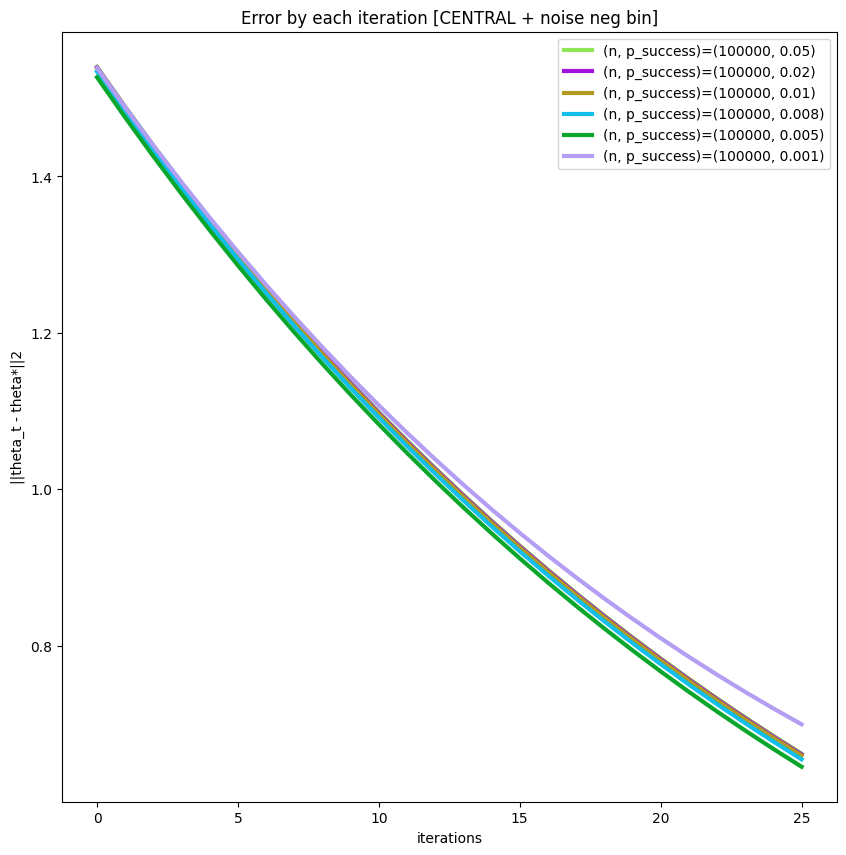

In [595]:
utils.plot_error_by_iteration_and_dict_key(
    centraol_noise_neg_bin_shorter,
    title=f'Error by each iteration [CENTRAL + noise neg bin]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(n, p_success)")

{(10000, 100): [2.961465496749137, 2.859522302412958, 2.7611228440293405, 2.666156830168403, 2.5744743594887605, 2.485969287676114, 2.4005380202883035, 2.3180632300554507, 2.238480901551782, 2.16166233770797, 2.0875124564532634, 2.0159518752560266, 1.9468741353148462, 1.880206496235877, 1.8158434954222307, 1.7537292642779037, 1.6937931465477867, 1.6359454329357246, 1.5801419733843176, 1.5262589651750618, 1.474296740076998, 1.4241370059340743, 1.375779373071646, 1.3290872113319672, 1.2840286878759757, 1.2405593021270034, 1.1986358652575637, 1.1582233886306756, 1.1192461405417646, 1.0816556540968423, 1.0454046135296886, 1.0104474613937597, 0.9767206775285401, 0.9442208598816614, 0.9128850537918562, 0.8826755151625124, 0.8535963974919787, 0.8255682967237578, 0.7985526338996779, 0.7725554893872387, 0.7475235649010797, 0.7234127980190964, 0.7001892884823302, 0.6779031014788814, 0.6564061835923028, 0.6357275066602199, 0.6158515633636324, 0.5967703482147629, 0.5784404992292027, 0.560826429424

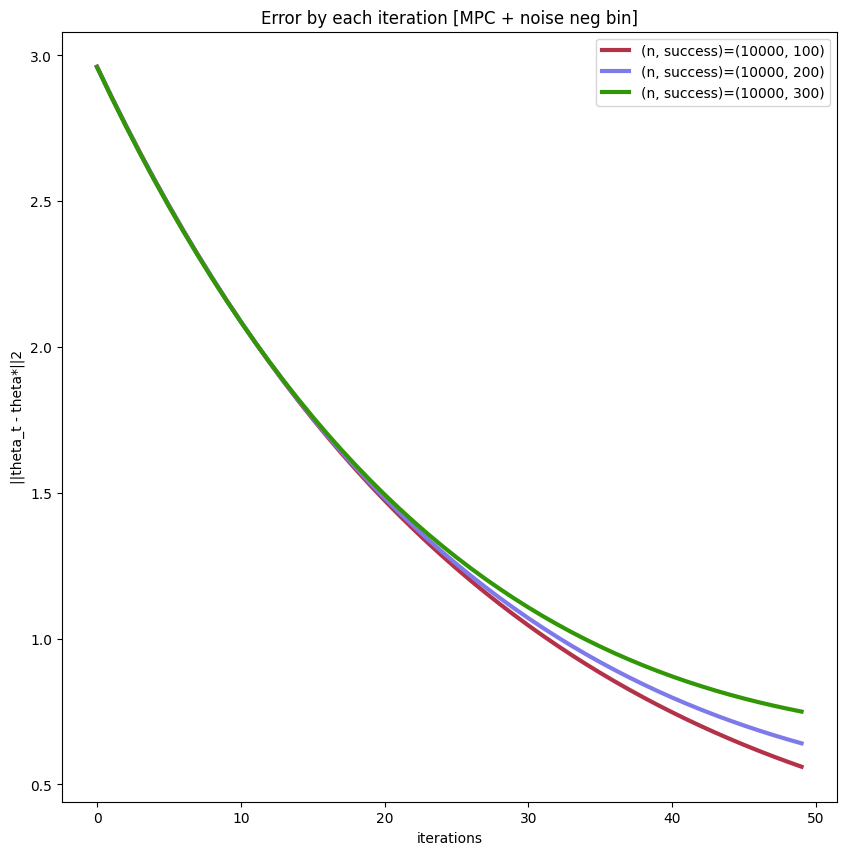

In [413]:
print(mpc_noise_neg_bin)
utils.plot_error_by_iteration_and_dict_key(
    mpc_noise_neg_bin,
    title=f'Error by each iteration [MPC + noise neg bin]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(n, success)")

In [409]:
def experiment_with_noise_gaussian(n_values, p, k, order=3, T_max=5):
    results_central = {}
    results_mpc = {}

    for n in n_values:

        # sample data
        data = utils.sample_dataset(n * (10 ** order), p, 0.05, k)

        # x_input = torch.tensor([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
        # theta_star = torch.tensor([140, 140, 140])
        # y_input = torch.tensor([10, 20, 30])

        p = len(data[0][0])
        for std in [0, 100, 200, 300]:
            noise = generate_gaussian_noise(0, std, p)

            # run central model
            start = time.time()
            it_err, _ = central_code.iht_central(data=data, noise=noise, k=k, T_max=T_max, eta=0.1, eps=0.01)
            end = time.time()
            print(f'[central] done with n={n, std}, with duration = {end - start}')
            results_central[(n * (10 ** order), std)] = it_err
            central_last = it_err[-1]
            central_n_it = len(it_err)

            start = time.time()
            it_err, _ = mpc_code.iht_mpc(data=data, noise=noise, k=k, T_max=T_max, eta=0.1, eps=0.01)
            end = time.time()
            print(f'[mpc] done with n={n, std}, with duration = {end - start}')
            results_mpc[(n * (10 ** order), std)] = it_err

            mpc_last = it_err[-1]
            mpc_n_it = len(it_err)

            print("CHECK, last iteration error difference central - mpc:", central_last - mpc_last)
            print(f'CHECK, number of iterations: {central_n_it} vs. {mpc_n_it}')

    return results_central, results_mpc

In [410]:
central_noise_gaussian, mpc_noise_gaussian = experiment_with_noise_gaussian(n_values=[1], p=64, k=54, order=4, T_max=50)

[central] done with n=(1, 0), with duration = 4.497983932495117
[mpc] done with n=(1, 0), with duration = 562.8002290725708
CHECK, last iteration error difference central - mpc: 3.3538633259388995e-05
CHECK, number of iterations: 50 vs. 50
[central] done with n=(1, 100), with duration = 4.476090908050537
[mpc] done with n=(1, 100), with duration = 558.7534070014954
CHECK, last iteration error difference central - mpc: 0.00039930195273407687
CHECK, number of iterations: 50 vs. 50
[central] done with n=(1, 200), with duration = 4.450273036956787
[mpc] done with n=(1, 200), with duration = 562.5740740299225
CHECK, last iteration error difference central - mpc: 0.00047175760830153735
CHECK, number of iterations: 50 vs. 50
[central] done with n=(1, 300), with duration = 5.124359130859375
[mpc] done with n=(1, 300), with duration = 563.0914318561554
CHECK, last iteration error difference central - mpc: 0.0011466929489736266
CHECK, number of iterations: 50 vs. 50


{(10000, 0): [2.9620966021735544, 2.860763019362967, 2.762927456412599, 2.668468114987472, 2.5772674724814912, 2.4892121307716835, 2.4041926703599548, 2.322103509709253, 2.2428427695879707, 2.1663121422431333, 2.0924167652293897, 2.021065099727051, 1.952168813188439, 1.8856426661575656, 1.8214044031137995, 1.7593746471954927, 1.6994767986647645, 1.6416369369796164, 1.585783726344384, 1.5318483246141459, 1.4797642954332095, 1.4294675234920895, 1.3808961327915545, 1.3339904078063236, 1.2886927174448484, 1.2449474417053552, 1.2027009009318763, 1.1619012875774961, 1.1224986003853357, 1.0844445809010301, 1.047692652233547, 1.0121978599841677, 0.9779168152663493, 0.9448076397419337, 0.9128299126018644, 0.8819446194221348, 0.8521141028281801, 0.8233020149033197, 0.7954732712791617, 0.7685940068481025, 0.7426315330402148, 0.7175542966088574, 0.6933318398713617, 0.6699347623530468, 0.647334683784684, 0.625504208405304, 0.6044168905239714, 0.5840472012958013, 0.5643704966690946, 0.54536298646201

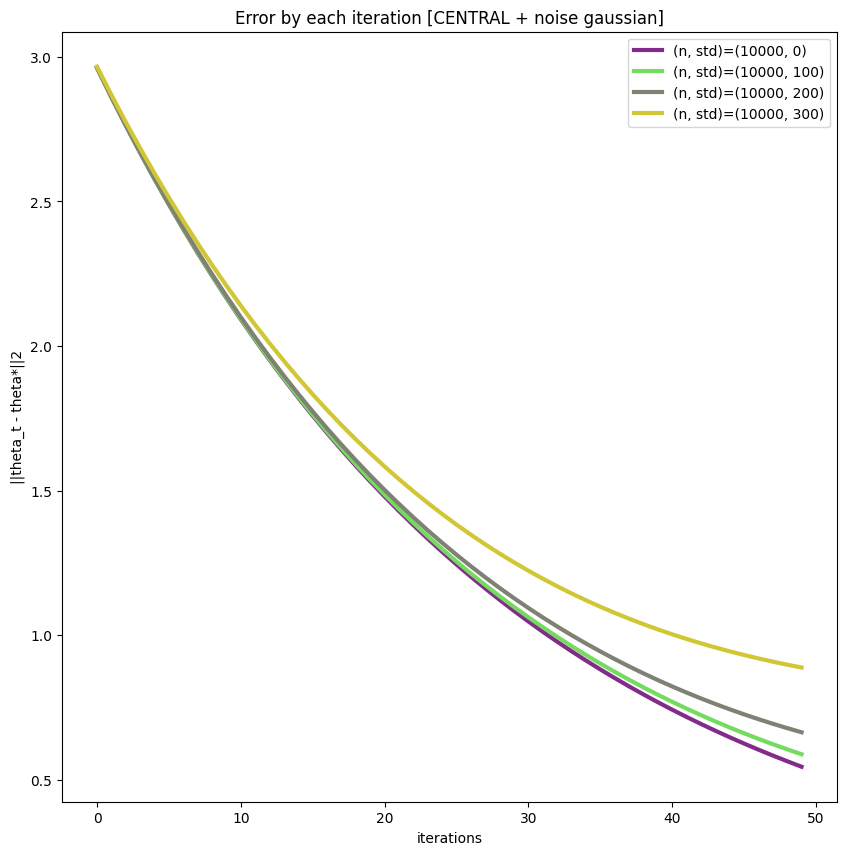

In [411]:
print(central_noise_gaussian)
utils.plot_error_by_iteration_and_dict_key(
    central_noise_gaussian,
    title=f'Error by each iteration [CENTRAL + noise gaussian]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(n, std)")

{(10000, 0): [2.962116982432121, 2.8607698480677173, 2.7629486225195934, 2.6684859311957365, 2.5772802972140654, 2.489210123715856, 2.4041801717951046, 2.3220918065917213, 2.242840636171183, 2.166314821641332, 2.0924227076596416, 2.021076190885981, 1.9521902397432809, 1.885674632925706, 1.821446785523447, 1.7594279460217834, 1.699528816949239, 1.6416836216519322, 1.5858379138817025, 1.5319106734278565, 1.4798196285522307, 1.4295013153545308, 1.3809464260956843, 1.3340467413766721, 1.2887449162557207, 1.2449779382690809, 1.202758310732422, 1.161962093743105, 1.1225661954765913, 1.0845101952399205, 1.0477528263842355, 1.0122163368273527, 0.9779163894595305, 0.9448204717812114, 0.9128222696788283, 0.8819706035825885, 0.8521498560588487, 0.8233400045324282, 0.7954742307921836, 0.7685818469229989, 0.7426323768292584, 0.7175759148167907, 0.6933740628504574, 0.6699801274543387, 0.6473604652193623, 0.6254925668976054, 0.604392084681316, 0.5839997784716788, 0.5643423058408058, 0.545329447828757

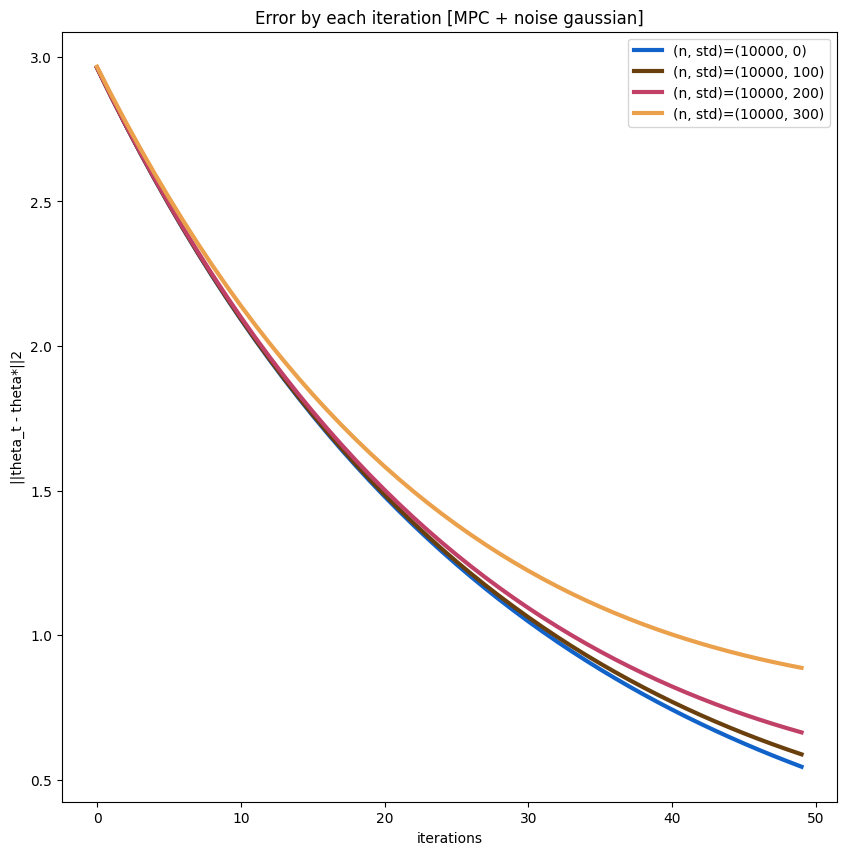

In [414]:
print(mpc_noise_gaussian)
utils.plot_error_by_iteration_and_dict_key(
    mpc_noise_gaussian,
    title=f'Error by each iteration [MPC + noise gaussian]',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(n, std)")